# Introduction

Single particle tracking (SPT) analysis involves many steps. This notebook assumes that the tracking has already been performed on a set of images with *TrackMate*. We start from a set of CSV files that contain at least X and Y positions and a trajectory label. The idea will be to turn these trajectories into mean square displacement curves (MSDs) and extract all of the features of interest which will be stored in list that can be turned into a DataFrame. 

In [291]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from DF_functions import mean_msd,covariance_msd,theoretical_mean_msd,theoretical_covariance,Michalet
from functions import data_pool,NormMSDSlopeError,NormMSDInterceptError,NormMSDSlopeError_exp,NormMSDInterceptError_exp,fix_heatmap,kolmogorov_smirnov
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=5
maxframe=500
rsquared_threshold=0.9

# Process raw data

The raw data is a list of CSV files. The `data_pool` function processes these CSVs and returns a list of observations that can readily be turned into a `DataFrame`. 

    DATA = data_pool(list of CSV files,
    time step for the experiment dt,
    minimum number of frames for the trajectories,
    maximum number of frames for the trajectories,
    minimum value for the quality of the MSD fit R**2,
    fit_option = number of points for the fit of the MSD,
    images = set of images in order to compute the cell's mean intensity)


In [292]:
files1 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
images1 = ["Data/SM1/sm1_stack.tif","Data/SM2/sm2_stack.tif","Data/SM3/sm3_stack.tif","Data/SM4/sm4_stack.tif","Data/SM5/sm5_stack.tif","Data/SM6/sm6_stack.tif","Data/SM7/sm7_stack.tif","Data/SM8/sm8_stack.tif","Data/SM9/sm9_stack.tif","Data/SM10/sm10_stack.tif"]

files2 = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
images2 = ["Data/SM1_WNT/sm1_wnt_stack.tif","Data/SM2_WNT/sm2_wnt_stack.tif","Data/SM3_WNT/sm3_wnt_stack.tif","Data/SM4_WNT/sm4_wnt_stack.tif","Data/SM5_WNT/sm5_wnt_stack.tif","Data/SM6_WNT/sm6_wnt_stack.tif","Data/SM7_WNT/sm7_wnt_stack.tif","Data/SM8_WNT/sm8_wnt_stack.tif","Data/SM10_WNT/sm10_wnt_stack.tif"]

DATA1 = data_pool(files1,dt,minframe,maxframe,rsquared_threshold,images=images1,fit_option=3)
DATA2 = data_pool(files2,dt,minframe,maxframe,rsquared_threshold,images=images2,fit_option=3)

/home/remy13127/Documents/Internship/functions.py:732: RuntimeWarning: divide by zero encountered in double_scalars
  rsquare = 1 - result.residual.var() / np.var(rhon[n0:nbrpts])


# Prepare DataFrames

The DATA-list contains either 9 or 10 features (if a set of images was provided). It is a list of $N_T$ observations and each observation is a set of 9-10 features. 

$$
\begin{pmatrix}
[ \alpha_1 & D_1 & c_1 & N_1 & \text{ID}_1 & X_1 & Y_1 & \text{MSD}_1 & \text{FILE}_1 & I_1 ]\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
[\alpha_{N_T} & D_{N_T} & c_{N_T} & N_{N_T} & \text{ID}_{N_T} & X_{N_T} & Y_{N_T} & \text{MSD}_{N_T} & \text{FILE}_{N_T} & I_{N_T}] \\
\end{pmatrix}
$$

Such an object can be readily turned into a dataframe with `pandas`. 

In [293]:
df1 = pd.DataFrame(DATA1,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
df2 = pd.DataFrame(DATA2,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
#Apply transformation to a column
df1['D'] = df1['D'].map(lambda x: np.log10(x))
df2['D'] = df2['D'].map(lambda x: np.log10(x))

df1.sample(10).head()

,alpha,D,c,N,ID,x,y,MSD,Filename,I
593,0.507703,-1.199735,0.010193,7,6536,"[67.516, 67.47, 67.539, 67.602, 67.671, 67.477...","[52.145, 52.207, 51.848, 51.895, 51.776, 51.82...","[0.05277399999999989, 0.08304179999999989, 0.0...",Data/SM1/sm1_ld400.csv,619
9382,0.547714,-1.157153,0.329478,5,5692,"[49.181999999999995, 49.075, 49.173, 49.489, 4...","[35.782, 35.713, 35.786, 35.646, 35.532]","[0.050898749999999236, 0.084651333333332, 0.09...",Data/SM9/sm9_ld400.csv,629
7071,1.046567,-1.039260,0.356338,8,5027,"[40.412, 40.316, 40.409, 40.381, 40.524, 40.51...","[38.37, 38.406, 38.339, 38.381, 38.26699999999...","[0.01982242857142855, 0.027671666666666348, 0....",Data/SM6/sm6_ld400.csv,595
5736,1.140465,-0.581248,0.258189,7,6018,"[34.211, 34.18, 34.148, 34.347, 34.542, 34.465...","[42.949, 42.823, 42.848, 42.891999999999996, 4...","[0.02918449999999991, 0.08237460000000014, 0.1...",Data/SM4/sm4_ld400.csv,618
3528,1.242314,-0.489865,0.518616,11,11732,"[20.256, 20.328, 20.308, 20.255, 20.314, 20.27...","[22.521, 22.607, 22.528000000000002, 22.456999...","[0.029978300000000187, 0.07565444444444452, 0....",Data/SM3/sm3_ld400.csv,640


In [294]:
display(df1.describe())
display(df2.describe())

,alpha,D,c,N,ID,I
count,10388.000000,10388.000000,10388.000000,10388.000000,10388.000000,10388.000000
mean,0.953993,-0.863766,0.420248,8.185021,7192.867732,629.542549
std,0.415393,0.647067,0.231867,4.941989,6494.785206,26.052960
min,0.002409,-3.226350,0.000000,5.000000,0.000000,580.000000
25%,0.652146,-1.302681,0.230086,5.000000,2402.750000,615.000000
50%,0.926511,-0.856128,0.405583,7.000000,5401.500000,630.000000
75%,1.249632,-0.398865,0.592970,9.000000,9884.250000,651.000000
max,2.150517,0.602060,1.000000,94.000000,30329.000000,730.000000


,alpha,D,c,N,ID,I
count,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000
mean,1.000090,-0.737274,0.445896,7.547849,9245.749517,638.550188
std,0.411289,0.623626,0.230069,4.089566,8417.708583,19.194911
min,0.024151,-3.225126,0.000000,5.000000,0.000000,598.000000
25%,0.700493,-1.155600,0.261450,5.000000,2825.000000,629.000000
50%,0.974456,-0.724314,0.436826,6.000000,6880.000000,639.000000
75%,1.295249,-0.296178,0.618479,8.000000,12979.000000,647.000000
max,2.033751,0.602060,1.000000,88.000000,39701.000000,690.000000


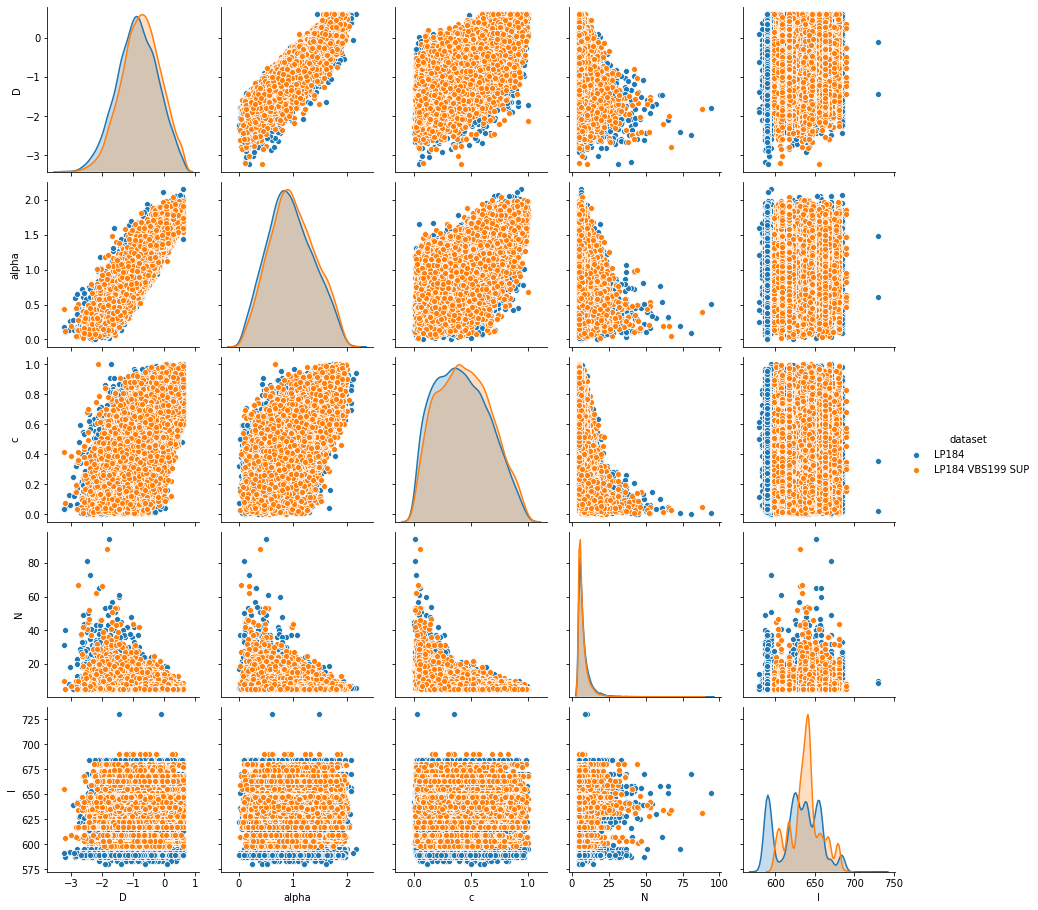

In [295]:
# Concatenate all data
concatenated = pd.concat([df1.assign(dataset='LP184'), df2.assign(dataset='LP184 VBS199 SUP')])
sns.pairplot(concatenated[['D','alpha','c','N','I','dataset']],hue='dataset')
plt.show()

#sns.pairplot(df1[['D','alpha','c','I','N']])
#sns.pairplot(df2[['D','alpha','c','I','N']])

# CDF analysis

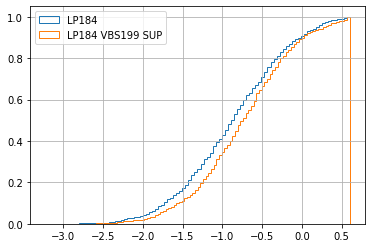

KS statistic =  0.095
bootstrap p-value =  0.0


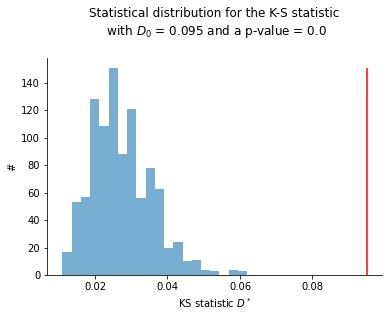

In [415]:
N = 1000
samp1 = df1.sample(N)
samp2 = df2.sample(N)

samp1['D'].hist(bins=100,density=True, histtype='step',cumulative=True, label='LP184')
samp2['D'].hist(bins=100,density=True,cumulative=True,histtype='step',label='LP184 VBS199 SUP')
plt.legend(loc='upper left')
plt.show()

stat,pvalue = kolmogorov_smirnov(list(samp1['D'].values),list(samp2['D'].values),plot=True,nloop=1000)

# Minframe analysis

Determining a minimum number of frames for your trajectory is a crucial step to minimize the number of false positives. But it also reduced considerably the amount of data you have at your disposal. 

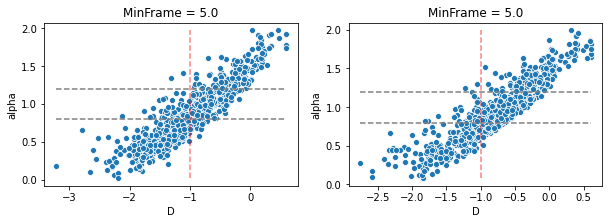

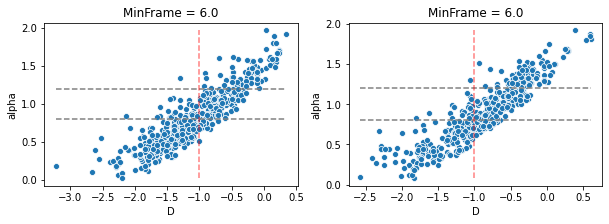

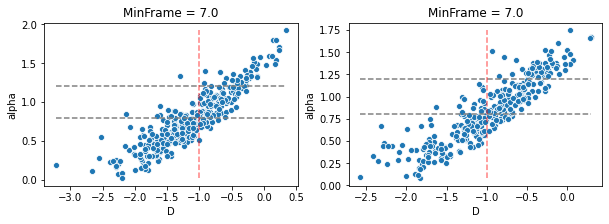

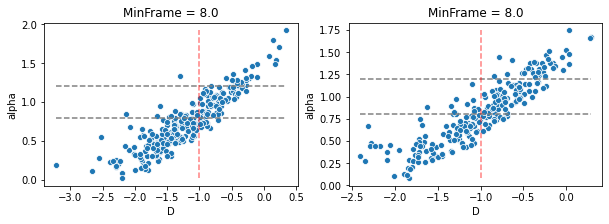

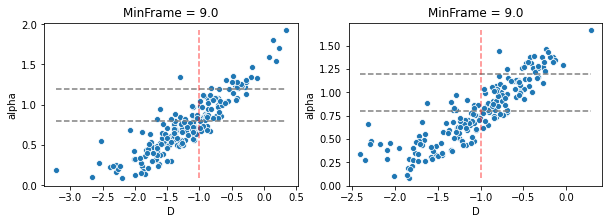

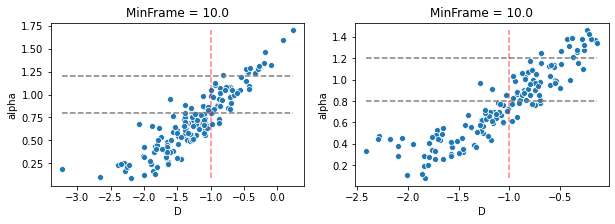

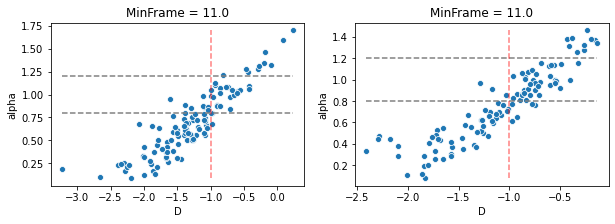

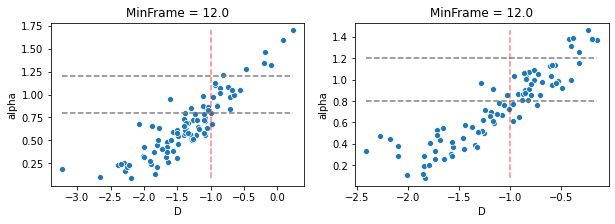

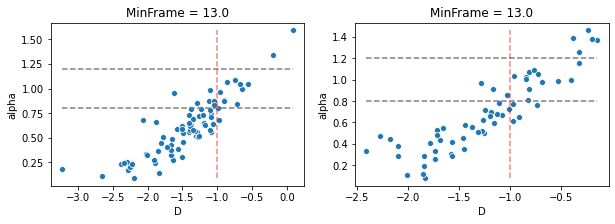

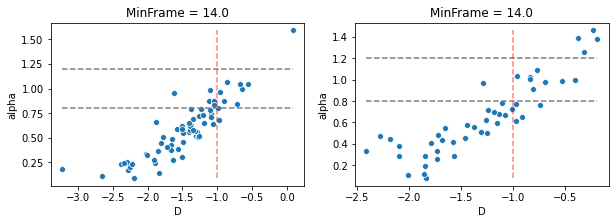

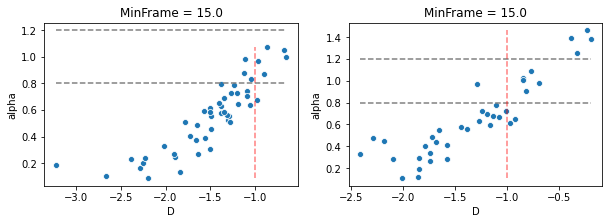

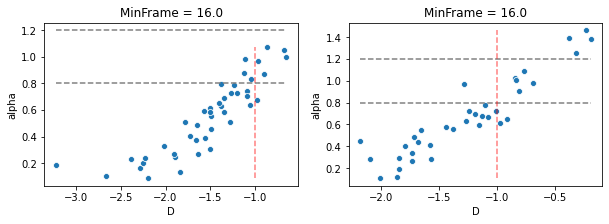

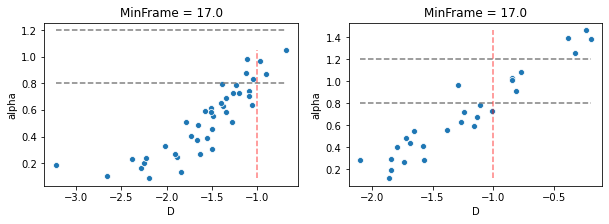

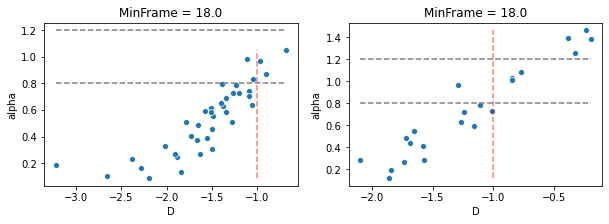

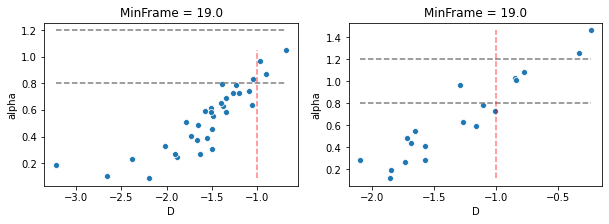

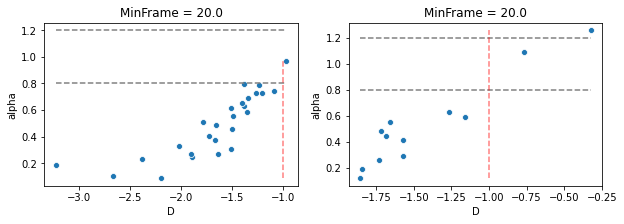

In [416]:
N = np.linspace(5,20,16)
for n in N:
    temp1 = samp1[(samp1['N']>n)]
    temp2 = samp2[(samp2['N']>n)]
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0])
    ax[0].hlines(0.8,min(temp1['D']),max(temp1['D']),linestyles='dashed',colors='gray')
    ax[0].hlines(1.2,min(temp1['D']),max(temp1['D']),linestyles='dashed',colors='gray')
    ax[0].vlines(-1,min(temp1['alpha']),max(temp1['alpha']),linestyles='dashed',colors='red',alpha=0.5)
    ax[0].set_title('MinFrame = '+str(n))
    
    sns.scatterplot(x='D',y='alpha',data=temp2,ax=ax[1])
    ax[1].hlines(0.8,min(temp2['D']),max(temp2['D']),linestyles='dashed',colors='gray')
    ax[1].hlines(1.2,min(temp2['D']),max(temp2['D']),linestyles='dashed',colors='gray')
    ax[1].vlines(-1,min(temp2['alpha']),max(temp2['alpha']),linestyles='dashed',colors='red',alpha=0.5)
    ax[1].set_title('MinFrame = '+str(n))

    plt.show()

# K-means on the data

We can use the K-Means to try to identify clusters in the data (but it is better if these clusters are already visible by eye). This way, we can isolate a group of points and perform any analysis we want on these points. 

In [423]:
number_of_clusters = 4
km = sklearn.cluster.KMeans(n_clusters=number_of_clusters)

cdata1 = samp1.loc[(samp1['N']>10)]
mat1 = cdata1[['alpha','D','c']].values
km.fit(mat1)
labels = km.labels_
cdata1['Label']=labels

cdata2 = samp2.loc[(samp2['N']>10)]
mat2 = cdata2[['alpha','D','c']].values
km.fit(mat2)
labels = km.labels_
cdata2['Label']=labels

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'D-$\\alpha$ plot for LP184 VBS199 SUP')

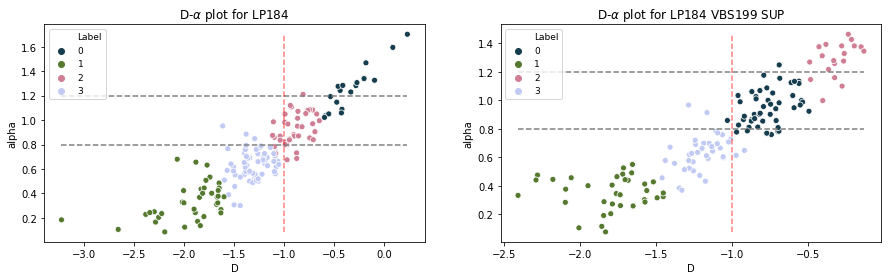

In [418]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
sns.scatterplot(x='D',y='alpha',data=cdata1,hue='Label',palette=sns.color_palette("cubehelix", number_of_clusters),ax=ax[0])
ax[0].hlines(0.8,min(cdata1['D']),max(cdata1['D']),linestyles='dashed',colors='gray')
ax[0].hlines(1.2,min(cdata1['D']),max(cdata1['D']),linestyles='dashed',colors='gray')
ax[0].vlines(-1,min(cdata1['alpha']),max(cdata1['alpha']),linestyles='dashed',colors='red',alpha=0.5)
ax[0].legend(fontsize=9)
ax[0].set_title(r'D-$\alpha$ plot for LP184')

sns.scatterplot(x='D',y='alpha',data=cdata2,hue='Label',palette=sns.color_palette("cubehelix", number_of_clusters),ax=ax[1])
ax[1].hlines(0.8,min(cdata2['D']),max(cdata2['D']),linestyles='dashed',colors='gray')
ax[1].hlines(1.2,min(cdata2['D']),max(cdata2['D']),linestyles='dashed',colors='gray')
ax[1].vlines(-1,min(cdata2['alpha']),max(cdata2['alpha']),linestyles='dashed',colors='red',alpha=0.5)
ax[1].legend(fontsize=9)
ax[1].set_title(r'D-$\alpha$ plot for LP184 VBS199 SUP')

# Free diffusion analysis on a subset of the data

We can try to isolate the most freely diffusing population from the data and estimate the diffusion coefficient using the known properties of Brownian systems. Michalet developed a full theoretical framework for Brownian trajectories. The characteristics of our supposedly Brownian data will be compared to Michalet's theoretical expressions with the `Michalet` function. 

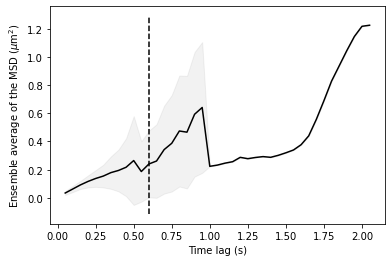

Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  3  for which the relative error sigma/b =  0.609354756834633
D =  0.144
It is estimated that the lowest error will be when the number of fitting points P =  4  for which the relative error sigmaa/a =  0.023433754275595003
sigma =  0.0441
Second run with accurate values for D and sigma.
D =  0.144
sigma =  0.0441
Done.


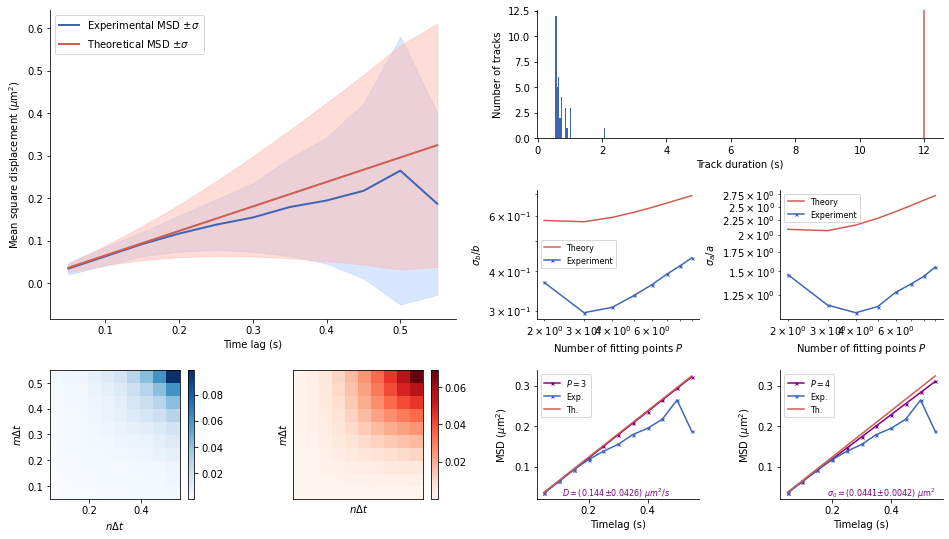

In [422]:
#Filter on alpha or select the cluster you're interested in
dfilt1 = cdata1[(cdata1['Label'].isin([2]))] 
dfilt2 = cdata2[(cdata2['Label'].isin([0]))]
#dfilt2 = df2[(df2['alpha']<1.1) & (df2['alpha']>0.9)]

#Select the Dataset and extract MSDs
MSDSeries1 = dfilt1['MSD'].values
cutoff1 = 0.6
Michalet(MSDSeries1,dt=dt,cutoff=cutoff1)
#mmsd,mvar,timelag = mean_msd(MSDSeries,cutoff=cutoff,show_cutoff=True)

#MSDSeries2 = dfilt2['MSD'].values
#cutoff2 = 0.7
#Michalet(MSDSeries2,dt=dt,cutoff=cutoff2)